In [1]:
# ปรับแต่งค่าการทำงานของ Spark
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("ChiSqSelector:Gender vs. Route").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1000m").\
        config("spark.executor.cores", "2").\
        config("spark.cores.max", "6").\
        getOrCreate()

23/06/24 11:43:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# กำหนดตัวแปร

HIGHDISPERSION_LIST= [] #เก็บชื่อคอลัมน์
HIGHNULL_LIST = [] #เก็บชื่อคอลัมน์
NULL_LIST = [] #เก็บชื่อคอลัมน์
NULL_PERC = 0.1 #สูงกว่าค่านี้ เป็น High Null ซึ่งอาจใช้วิธีลบทั้ง row ที่มี null ไม่ได้ เพราะอาจทำให้สูญเสียทั้ง row ไปเยอะเกินควร
DISPERSION_PERC = 100 #สูงกว่าค่านี้ (%) เป็น High Dispersion

In [3]:
from pyspark.sql import functions as sparkf
from pyspark.sql.types import *

In [4]:
#! pip install scipy

In [5]:
# เรียกใช้ Module/Library ของ Python

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [6]:
# ประกาศฟังก์ชั่นที่ใช้ทำ Histogram กับ Boxplot เพื่อวิเคราะห์ distribution (shape), outlier และความสัมพันธ์ (correlation)

def plot_var(arg_df, col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(arg_df.loc[arg_df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(x=arg_df[col_name], order=sorted(arg_df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=arg_df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = arg_df.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of arg_df Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()



## 1. Business Understaing
    
    1.1 Problem Statement: ต้องการทราบว่า ลูกหนี้แต่ละรายจะมาจ่ายหนี้ครบตามสัญญาเงินกู้ (Fully-paid) หรือไม่มาจ่ายฯ (Charged-off)
    1.2 Project Objective: การจัดเก็บหนี้ดีขึ้นช่วยเพิ่มรายได้ให้กับกิจการ
    1.3 Task of Data Science: Binary Classification
    1.4 Cleansing Policy: ธุรกิจมี columns ที่แนะนำว่ามีความสัมพันธ์/ส่งผลต่อการชำระหนี้คืนตามสัญญา, ลบได้ทั้ง row หากมี missing ใน columns และแทนที่ได้ตามความเหมาะสม
    1.5 Success Criteria: มี Recall/Sensitivity ไม่น้อยกว่า 0.65 บน Testing set แบบ Hold-out

## 2. Data Understanding
    
    - มี Label เป็น column: loan_status
    - มีขนาดใหญ่ (volume)เกินกว่าเทคโนโลยีปัจจุบัน (Python) จะทำงานได้อย่างมีประสิทธิภาพ จึงต้องใช้ Spark ร่วมด้วย
    - CSV เป็น semi-structural data ที่มี header ซึ่งสามารถนำไปพัฒนาเป็น schema ของ structural data (Spark DataFrame) ได้
    - Data Dict.: https://docs.google.com/spreadsheets/d/1qtZBSJ-JS7S2tGC0W9Yxp992LmrDaAwGcJB419Htbbw/edit#gid=1163295822

In [7]:
#กำหนด columns ที่ธุรกิจให้คำแนะนำฯ ไว้

businessAttrs_df = ["loan_amnt","term","int_rate"\
                                ,"installment","grade","emp_length",\
                           "home_ownership","annual_inc"\
                                ,"verification_status","loan_status",\
                           "purpose","addr_state","dti","delinq_2yrs"\
                                ,"earliest_cr_line",\
                           "open_acc","pub_rec"\
                                ,"revol_bal","revol_util","total_acc","issue_d"]

In [8]:
#! apt-get install wget -y

In [9]:
#! wget https://storage.googleapis.com/ntclass/LoanStats_web.csv

In [10]:
! wc -l LoanStats_web.csv

1432493 LoanStats_web.csv


In [11]:
! head -3 LoanStats_web.csv

"id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade","emp_title","emp_length","home_ownership","annual_inc","verification_status","issue_d","loan_status","pymnt_plan","url","desc","purpose","title","zip_code","addr_state","dti","delinq_2yrs","earliest_cr_line","inq_last_6mths","mths_since_last_delinq","mths_since_last_record","open_acc","pub_rec","revol_bal","revol_util","total_acc","initial_list_status","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","next_pymnt_d","last_credit_pull_d","collections_12_mths_ex_med","mths_since_last_major_derog","policy_code","application_type","annual_inc_joint","dti_joint","verification_status_joint","acc_now_delinq","tot_coll_amt","tot_cur_bal","open_acc_6m","open_act_il","open_il_12m","open_il_24m","mths_since_rcnt_il","total_bal_il","il_util","open_rv_1

In [12]:
# Spark อ่านข้อมูลจาก .csv แล้ว convert เป็น DataFrame

raw_df = spark.read.option('header',True)\
.option("quote", "\"")\
.option('mode','DROPMALFORMED')\
.option('inferSchema',True)\
.csv('LoanStats_web.csv')\
.select(businessAttrs_df)

In [13]:
# Spark นับจำนวน row ใน DataFrame

raw_df.count()

23/06/24 11:43:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


1432466

In [14]:
raw_df.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- pub_rec: integer (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- issue_d: string (nullable = true)



In [15]:
allRows_count = raw_df.count()

### 2.1 Univariate Analysis

In [16]:
# Spark วิเคราะห์ column แล้วแสดงค่าทางสถิติ 5 ค่า ของแต่ละ column โดยมี Python Pandas ช่วยในการแสดงผล

raw_df.describe().toPandas().transpose()

#### ผลจากการดู Range ขัอเกต คือ annual_inc มี 0 ด้วย

,0,1,2,3,4
summary,count,mean,stddev,min,max
loan_amnt,1432440,15370.388358325654,9646.026272413836,1000,40000
term,1432440,None,None,36 months,60 months
int_rate,1432440,None,None,5.31%,30.99%
installment,1432440,456.68909888718275,281.7139997355062,19.4,1715.42
grade,1432440,None,None,A,G
emp_length,1432440,None,None,1 year,n/a
home_ownership,1432440,None,None,ANY,RENT
annual_inc,1432440,81034.58293296752,134183.35696714383,0.0,6.1E7
verification_status,1432440,None,None,Not Verified,Verified


In [17]:
#### ขยายผลกลุ่ม annual_inc = 0 ต่อไป เพื่อดูว่า ปล่อยกู้ในกลุ่มนี้ ยังงัยบ้าง
raw_df.filter(sparkf.col('annual_inc')==0).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
loan_amnt,1553,19987.411461687057,11113.147359296125,1000,40000
term,1553,None,None,36 months,60 months
int_rate,1553,None,None,5.31%,30.79%
installment,1553,572.9260785576306,325.60197159326947,33.57,1597.6
grade,1553,None,None,A,G
emp_length,1553,None,None,1 year,n/a
home_ownership,1553,None,None,MORTGAGE,RENT
annual_inc,1553,0.0,0.0,0.0,0.0
verification_status,1553,None,None,Not Verified,Verified


In [18]:
#### code ก่อนหน้านี้เห็นว่า กลุ่ม annual_inc = 0 มีการปล่อยกู้ด้วยวงเงินสูงสุด 40,000
#### code ในส่วนนี้ เห็นว่า คนที่ได้รับเงินกู้ไป 40,000 มีจำนวน 126 คน ซึ่งมากที่สุดแล้วในกลุ่ม annual_inc = 0
raw_df.filter(sparkf.col('annual_inc')==0).groupBy('loan_amnt').count()\
.orderBy('count', ascending=False).show()

+---------+-----+
|loan_amnt|count|
+---------+-----+
|    40000|  126|
|    20000|   94|
|    10000|   87|
|    35000|   85|
|    15000|   80|
|    30000|   75|
|    12000|   73|
|    25000|   58|
|    16000|   56|
|    24000|   54|
|     5000|   44|
|     8000|   42|
|    32000|   36|
|    18000|   31|
|     6000|   25|
|    28000|   21|
|    14000|   18|
|    11000|   17|
|     7000|   16|
|    13000|   16|
+---------+-----+
only showing top 20 rows



In [19]:
# Spark และ Pandas ร่วมกันคำนวณ Coefficient of Variation (CV)

basicStat_pd = raw_df.describe().toPandas().transpose()

header_series = basicStat_pd.iloc[0]

noColBasicStat_pd = basicStat_pd[1:]

noColBasicStat_pd.columns = header_series

basicStat_pd = noColBasicStat_pd

basicStat_pd = basicStat_pd[['count','mean','stddev']].astype('float64')

basicStat_pd = basicStat_pd.assign(CV=lambda x: round((x['stddev']/x['mean'])*100,2))\
.sort_values('CV',ascending=False)
basicStat_pd

summary,count,mean,stddev,CV
delinq_2yrs,1432440.0,0.301472,0.864319,286.70
pub_rec,1432439.0,0.205392,0.586109,285.36
annual_inc,1432440.0,81034.582933,134183.356967,165.59
revol_bal,1432439.0,16846.678102,23301.014583,138.31
dti,1430856.0,19.211873,15.972775,83.14
loan_amnt,1432440.0,15370.388358,9646.026272,62.76
installment,1432440.0,456.689099,281.714000,61.69
total_acc,1432440.0,23.602901,12.040983,51.01
open_acc,1432440.0,11.710319,5.841056,49.88
term,1432440.0,NaN,NaN,NaN


In [20]:
# Spark และ Pandas ร่วมกันกรองออกมาเฉพาะ CV ที่เกิน DISPERSION_PERC

basicStat_pd[basicStat_pd.assign(CV=lambda x: round((x['stddev']/x['mean'])*100,2))\
.sort_values('CV',ascending=False)['CV']>DISPERSION_PERC]

summary,count,mean,stddev,CV
delinq_2yrs,1432440.0,0.301472,0.864319,286.70
pub_rec,1432439.0,0.205392,0.586109,285.36
annual_inc,1432440.0,81034.582933,134183.356967,165.59
revol_bal,1432439.0,16846.678102,23301.014583,138.31


In [21]:
# Spark และ Pandas ได้รับรายชื่อ Col. ที่มี Dispersion เกินกว่าค่า DISPERSION_PERC
HIGHDISPERSION_LIST = basicStat_pd[basicStat_pd.assign(CV=lambda x: round((x['stddev']/x['mean'])*100,2))\
.sort_values('CV',ascending=False)['CV']>DISPERSION_PERC][:].axes[0].values.tolist()

In [22]:
HIGHDISPERSION_LIST

['delinq_2yrs', 'pub_rec', 'annual_inc', 'revol_bal']

In [23]:
raw_df.count()

1432466

In [24]:
#วิเคราะห์ NULL

basicStat_pd.assign(percentageNull=lambda x: ((allRows_count-x['count'])/allRows_count)*100)\
.sort_values('percentageNull',ascending=False)

summary,count,mean,stddev,CV,percentageNull
dti,1430856.0,19.211873,15.972775,83.14,0.112394
revol_util,1431251.0,19.000000,NaN,NaN,0.084819
revol_bal,1432439.0,16846.678102,23301.014583,138.31,0.001885
pub_rec,1432439.0,0.205392,0.586109,285.36,0.001885
delinq_2yrs,1432440.0,0.301472,0.864319,286.70,0.001815
emp_length,1432440.0,NaN,NaN,NaN,0.001815
earliest_cr_line,1432440.0,NaN,NaN,NaN,0.001815
addr_state,1432440.0,NaN,NaN,NaN,0.001815
purpose,1432440.0,NaN,NaN,NaN,0.001815
loan_status,1432440.0,NaN,NaN,NaN,0.001815


In [25]:
# Spark และ Pandas ได้รับรายชื่อ Col. ที่มี Null เกินกว่าค่า NULL_PERC

HIGHNULL_LIST = basicStat_pd[basicStat_pd.assign(percentageNull=lambda x: ((allRows_count-x['count'])/allRows_count)*100)\
.sort_values('percentageNull',ascending=False)['percentageNull']>NULL_PERC][:].axes[0].values.tolist()

In [26]:
HIGHNULL_LIST

['dti']

In [27]:
# Spark และ Pandas ได้รับรายชื่อ Col. ที่มี Null 
NULL_LIST = basicStat_pd[basicStat_pd.assign(countNull=lambda x: allRows_count-x['count'])\
.sort_values('countNull',ascending=False)['countNull']>0][:].axes[0].values.tolist()

In [28]:
# Spark วิเคราะห์ Imbalance Class

raw_df.groupBy('loan_status').count().show()

+------------------+------+
|       loan_status| count|
+------------------+------+
|        Fully Paid|551955|
|           Default|    27|
|              null|    26|
|   In Grace Period|  7928|
|       Charged Off|147348|
|Late (31-120 days)| 18752|
|           Current|702223|
| Late (16-30 days)|  4207|
+------------------+------+



In [29]:
raw_df.select('loan_status').distinct().show()

+------------------+
|       loan_status|
+------------------+
|        Fully Paid|
|           Default|
|              null|
|   In Grace Period|
|       Charged Off|
|Late (31-120 days)|
|           Current|
| Late (16-30 days)|
+------------------+



In [30]:
raw_df.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- pub_rec: integer (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- issue_d: string (nullable = true)



In [31]:
raw_df.withColumn('calculatedDTI',sparkf.col('loan_amnt')/sparkf.col('annual_inc'))\
.select('loan_amnt','annual_inc','dti','calculatedDTI').groupBy('loan_amnt','annual_inc','dti','calculatedDTI').count()\
.orderBy('dti', ascending=False).show()

### ค่า dti เชื่อถือได้หรือไม่

+---------+----------+------------------+-------------------+-----+
|loan_amnt|annual_inc|               dti|      calculatedDTI|count|
+---------+----------+------------------+-------------------+-----+
|     8800|   65000.0|Debt consolidation|0.13538461538461538|    1|
|    12300|      23.0|               999|  534.7826086956521|    1|
|    15600|    1000.0|               999|               15.6|    1|
|    17500|    1158.0|               999| 15.112262521588946|    1|
|    20000|    1500.0|               999| 13.333333333333334|    1|
|    12000|    1680.6|               999|  7.140307033202428|    1|
|     3750|     500.0|               999|                7.5|    1|
|    10000|      36.0|               999| 277.77777777777777|    1|
|    35000|    1000.0|               999|               35.0|    7|
|    10000|     420.0|               999|  23.80952380952381|    1|
|    10250|      33.0|               999|  310.6060606060606|    1|
|    40000|     938.0|               999| 42.643

In [32]:
raw_df.withColumn('calculatedDTI',sparkf.col('loan_amnt')/sparkf.col('annual_inc'))\
.select('loan_amnt','annual_inc','dti','calculatedDTI').filter(sparkf.col('calculatedDTI').isNull()).show()

#### พบว่า มี annual_inc = 0 แต่ได้รับเงินกู้ ซึ่งไม่ควรให้ ML จดจำ pattern แบบนี้ไปใช้**

+---------+----------+----+-------------+
|loan_amnt|annual_inc| dti|calculatedDTI|
+---------+----------+----+-------------+
|     2500|       0.0|null|         null|
|    12000|       0.0|null|         null|
|    15000|       0.0|null|         null|
|     9100|       0.0|null|         null|
|    17500|       0.0|null|         null|
|    18000|       0.0|null|         null|
|     5000|       0.0|null|         null|
|     8400|       0.0|null|         null|
|    20000|       0.0|null|         null|
|    15000|       0.0|null|         null|
|    17600|       0.0|null|         null|
|    16500|       0.0|null|         null|
|    24975|       0.0|null|         null|
|     9900|       0.0|null|         null|
|    15000|       0.0|null|         null|
|     null|      null|null|         null|
|     null|      null|null|         null|
|    12000|       0.0|null|         null|
|    15000|       0.0|null|         null|
|    20000|       0.0|null|         null|
+---------+----------+----+-------

### 2.2 Bivariate/Multivariate Analysis

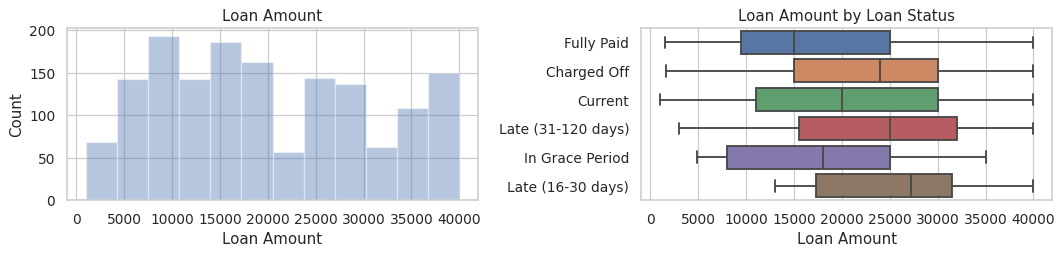

In [33]:
# Spark และ Python ร่วมกันวิเคราะห์หา Distribution (Shape), Outlier และ Correlation ด้วยการใช้เทคนิค Histogram, Boxplot

plot_var(raw_df.filter(sparkf.col('annual_inc') == 0).toPandas(),'loan_amnt', 'Loan Amount', continuous=True)

### แสดงการแจกแจงความถี่ของ Loan Amount และความสัมพันธ์ระหว่าง Loan Amount กับ Loan Status เฉพาะลูกหนี้ที่ไม่มีรายได้

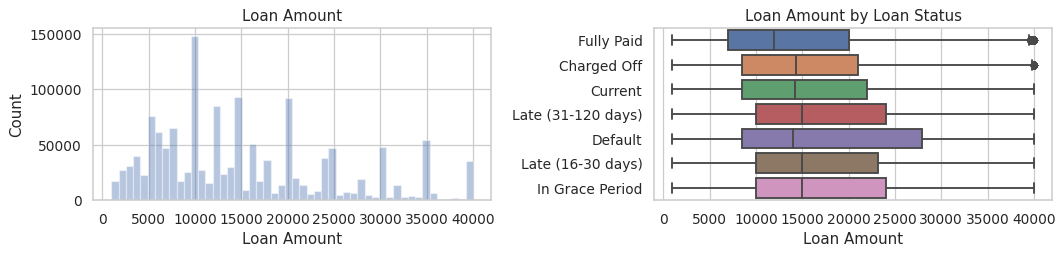

In [34]:
plot_var(raw_df.filter(sparkf.col('annual_inc') != 0).toPandas(),'loan_amnt', 'Loan Amount', continuous=True)

### แสดงการแจกแจงความถี่ของ Loan Amount และความสัมพันธ์ระหว่าง Loan Amount กับ Loan Status เฉพาะลูกหนี้ที่มีรายได้

#### เปรียบเทียบผลจาก code ก่อนหน้านี้ กับ code บรรทัดนี้ ทำให้เห็นว่า ลูกหนี้ที่ annual_inc = 0 มี median ของ loan_amnt ระหว่างคนจ่ายหนี้ครบ กับ คนเบี้ยวหนี้ ต่างกันอย่างมาก
#### แตกต่างจาก annual_inc != 0 มี median ของ loan_amnt ระหว่างคนจ่ายหนี้ครบ กับ คนเบี้ยวหนี้ ต่างกันอยู่พอสมควร แต่ไม่มากเท่ากรณีแรก
#### เช่นทำให้คิดต่อไปว่า หากมีข้อมูลมากพออาจแยก train เป็น 2 model คือ model สำหรับ annual_inc = 0 กับ annual_inc !=0 

In [35]:
# Spark และ Python ร่วมกัน นำ % sign ออกจาก revol_util เพื่อนำไปใช้วิเคราะห์ใน block code ถัดไป

correctedRevolUtil_pd = raw_df.withColumn('revol_util',sparkf.when(sparkf.col('revol_util').isNotNull()\
                                                                   ,sparkf.regexp_replace(sparkf.col('revol_util'),'%',''))\
                  .otherwise(sparkf.col('revol_util')))\
.withColumn('revol_util',sparkf.col('revol_util').cast(FloatType())).toPandas()

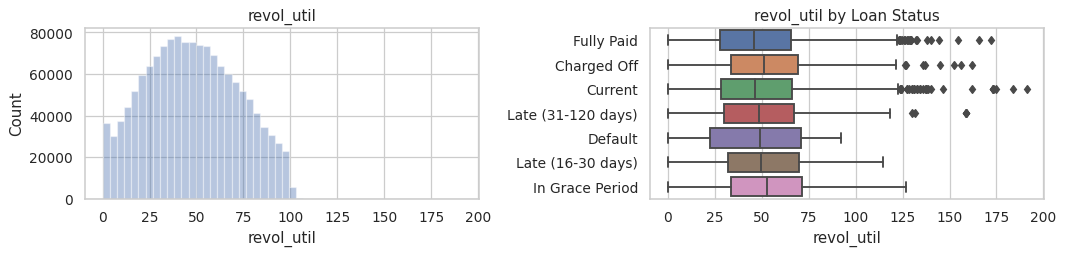

In [36]:
# Spark และ Python ร่วมกันวิเคราะห์หา Distribution (Shape), Outlier และ Correlation ด้วยการใช้เทคนิค Histogram, Boxplot

plot_var(correctedRevolUtil_pd,'revol_util', 'revol_util', continuous=True)

In [37]:
#### Spark และ Python ร่วมกัน นำ % sign ออกจาก revol_util และเอา outlier ทิ้งไป เพื่อนำไปใช้วิเคราะห์ใน block code ถัดไป

noOutlier_correctedRevolUtil_pd = raw_df.withColumn('revol_util',sparkf.when(sparkf.col('revol_util').isNotNull()\
                                                                   ,sparkf.regexp_replace(sparkf.col('revol_util'),'%',''))\
                  .otherwise(sparkf.col('revol_util')))\
.withColumn('revol_util',sparkf.col('revol_util').cast(FloatType()))\
.filter(sparkf.col('revol_util') < 120)\
.toPandas()

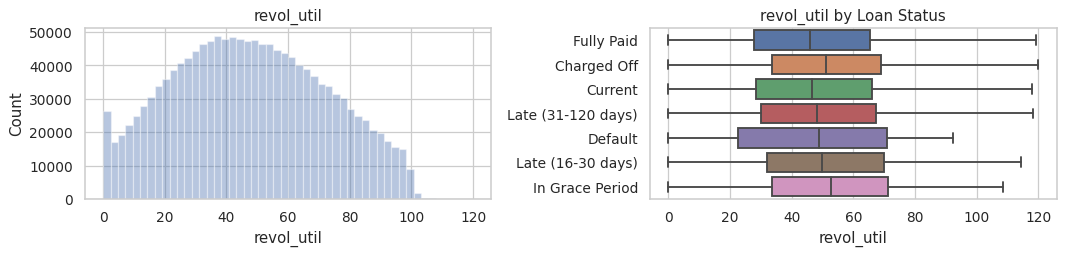

In [38]:
#### Spark และ Python ร่วมกันวิเคราะห์หา Distribution (Shape), Outlier และ Correlation ด้วยการใช้เทคนิค Histogram, Boxplot

plot_var(noOutlier_correctedRevolUtil_pd,'revol_util', 'revol_util', continuous=True) ##กรณีนี้ไม่มี outlier ที่ revol util แล้ว

In [ ]:
# Spark และ Python ร่วมกัน casting type ที่ delinq_2yrs เพื่อนำไปใช้วิเคราะห์ใน block code ถัดไป

correctedDelinq_2yrs_pd = raw_df.withColumn('delinq_2yrs',sparkf.col('delinq_2yrs').cast(FloatType())).toPandas()

In [ ]:
# Spark และ Python ร่วมกันวิเคราะห์หา Distribution (Shape), Outlier และ Correlation ด้วยการใช้เทคนิค Histogram, Boxplot

plot_var(correctedDelinq_2yrs_pd,'delinq_2yrs', 'delinq_2yrs', continuous=True)

In [ ]:
raw_df.withColumn('delinq_2yrs',sparkf.col('delinq_2yrs').cast(FloatType())).select('delinq_2yrs').describe().show()

In [ ]:
#### Spark และ Python ร่วมกัน casting type ที่ delinq_2yrs เพื่อนำไปใช้วิเคราะห์ใน block code ถัดไป

noOutlier_correctedDelinq_2yrs_pd = raw_df.withColumn('delinq_2yrs',sparkf.col('delinq_2yrs').cast(FloatType()))\
.filter(sparkf.col('delinq_2yrs')<1.0).toPandas()

In [ ]:
#### Spark และ Python ร่วมกันวิเคราะห์หา Distribution (Shape), Outlier และ Correlation ด้วยการใช้เทคนิค Histogram, Boxplot

plot_var(noOutlier_correctedDelinq_2yrs_pd,'delinq_2yrs', 'delinq_2yrs', continuous=True)

In [ ]:
#raw_df.select('delinq_2yrs').describe().show()

In [ ]:
#raw_df.select('delinq_2yrs').withColumn('delinq_2yrs',sparkf.col('delinq_2yrs').cast(FloatType())).describe().show()

## 3. Data Preparation

In [ ]:
#### ใหม่ ณ 16 JAN 2023
# ใช้ Spark ปรับแต่งค่าใน column: annual_inc, loan_status, revol_util, int_rate และ issue_d
# ใช้ Spark สร้าง column ใหม่ขึ้นมา คือ calculatedDTI

crunched_df = raw_df\
.filter(sparkf.col('annual_inc') != 0)\
.filter((sparkf.col('loan_status') == 'Fully Paid')|(sparkf.col('loan_status') == 'Charged Off'))\
.withColumn('calculatedDTI',sparkf.col('loan_amnt')/sparkf.col('annual_inc'))\
.withColumn('revol_util',sparkf.when(sparkf.col('revol_util').isNotNull(),sparkf.regexp_replace(sparkf.col('revol_util'),'%',''))\
                  .otherwise(sparkf.col('revol_util')))\
.filter(sparkf.col('revol_util') < 120)\
.withColumn('int_rate',sparkf.when(sparkf.col('int_rate').isNotNull(),sparkf.regexp_replace(sparkf.col('int_rate'),'%',''))\
                  .otherwise(sparkf.col('int_rate')))\
.withColumn('issue_d',sparkf.regexp_extract(sparkf.col('issue_d'),'\d+',0))\
.withColumn('revol_util',sparkf.col('revol_util').cast(IntegerType()))\
.withColumn('int_rate',sparkf.col('int_rate').cast(FloatType()))\
.withColumn('issue_d',sparkf.col('issue_d').cast(IntegerType()))\
.withColumn('delinq_2yrs',sparkf.col('delinq_2yrs').cast(FloatType()))\
.dropna()

In [ ]:
crunched_df.describe().toPandas().transpose()

In [ ]:
crunched_df.printSchema()

In [ ]:
crunched_pd = crunched_df.toPandas()

In [ ]:
plot_var(crunched_pd,'loan_amnt', 'Loan Amount', continuous=True)

In [ ]:
import scipy.stats as stats

# การคำนวณ p-value จากการทดสอบ t-test สำหรับการเปรียบเทียบค่าเฉลี่ยของ loan_amnt ระหว่าง loan_status
group1 = crunched_pd[crunched_pd["loan_status"] == "Fully Paid"]["loan_amnt"]
group2 = crunched_pd[crunched_pd["loan_status"] == "Charged Off"]["loan_amnt"]

t_stat, p_value = stats.ttest_ind(group1, group2)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

In [ ]:
plot_var(crunched_pd,'annual_inc', 'Annual Income', continuous=True)

In [ ]:
#เมื่อทดลองเอา Outlier ออก แล้ว ทดสอบความสัมพันธ์ด้วย boxplot อีกครั้ง
plot_var(crunched_df.filter(sparkf.col('annual_inc')<150000).toPandas(),'annual_inc', 'Annual Income', continuous=True)

In [ ]:
plot_var(crunched_pd,'int_rate', 'Interest Rate', continuous=True)

In [ ]:
import scipy.stats as stats

# การคำนวณ p-value จากการทดสอบ t-test สำหรับการเปรียบเทียบค่าเฉลี่ยของ int_rate ระหว่าง loan_status
group1 = crunched_pd[crunched_pd["loan_status"] == "Fully Paid"]["int_rate"]
group2 = crunched_pd[crunched_pd["loan_status"] == "Charged Off"]["int_rate"]

t_stat, p_value = stats.ttest_ind(group1, group2)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

In [ ]:
plot_var(crunched_df.filter(((sparkf.col('int_rate')<22)&(sparkf.col('loan_status')=='Fully Paid'))|((sparkf.col('loan_status')=='Charged Off')\
                                                                                                     &(sparkf.col('int_rate')<28))).toPandas()\
         ,'int_rate', 'Interest Rate', continuous=True)

In [ ]:
# Spark สร้าง ABT

final_df = crunched_df\
.filter(sparkf.col('annual_inc')<150000)\
.filter(((sparkf.col('int_rate')<22)&(sparkf.col('loan_status')=='Fully Paid'))|((sparkf.col('loan_status')=='Charged Off')&(sparkf.col('int_rate')<28)))## กรอง Outlier ออก

In [ ]:
final_df.describe().toPandas().transpose()

In [ ]:
final_df.printSchema()

In [ ]:
# สรุป column ที่เราพิจารณาว่าเป็น high dispersion, มี null เกินกว่าที่กำหนดไว้ และมี null อยู่ใน column

In [ ]:
HIGHDISPERSION_LIST

In [ ]:
HIGHNULL_LIST

In [ ]:
NULL_LIST